In [1]:
%%capture
!pip install pytorch-lightning

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
EMB_DIM = 128
NUM_OF_VERTICES=64719

full_path = "./drive/MyDrive/science4cast/20220203/"

edg_fns = os.listdir(os.path.join(full_path, 'emb'))

In [10]:
import matplotlib.pyplot as plt
from math import isclose
import numpy as np
import pickle
import pandas as pd
import random
import time
from datetime import date
from collections import Counter
import multiprocessing
from sklearn.model_selection import train_test_split

In [6]:
def compute_embedding_features(filename):
    with open(os.path.join(filename), "rb") as output_file:
        df = pd.read_csv(output_file, skiprows=1, header=None, sep=' ')
        node_embeddings = 2*np.random.rand(NUM_OF_VERTICES, EMB_DIM)-1
        node_embeddings[df[0]] = df.iloc[:, 1:]
    return node_embeddings

In [7]:
def filter(datalist, key):
    # Search data based on regular expression in the list
    return [val for val in datalist if key in val]

def filter_by_year(full_graph, yy):
  day_origin = date(1990, 1, 1)
  day_curr = date(yy, 12, 31)
  return full_graph[full_graph[:,2]<(day_curr-day_origin).days]

# Pretrain transformers for embedding

In [8]:
import pytorch_lightning as pl
import transformers
import math
from scipy.linalg import orthogonal_procrustes

import torch
import torch.nn as nn

class PositionalEncoding(pl.LightningModule):
  def __init__(self, d_model, dropout=0.0, max_len=18):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
  
  def forward(self, x):
    x = x + self.pe[:x.size(1), :]
    return self.dropout(x)

class MLP(pl.LightningModule):
  def __init__(self, output_dim, input_dim = 128):
    super().__init__()
    self.mlp = torch.nn.Sequential(nn.Linear(input_dim, input_dim),
                                   nn.ReLU(),
                                   nn.Linear(input_dim, output_dim),
                                   nn.ReLU(),
                                   nn.Linear(output_dim,output_dim))
  
  def forward(self, x):
    return self.mlp(x)

class Transformer(pl.LightningModule):
  def __init__(self, output_size, wm, ms):
    super().__init__()
    self.positional = PositionalEncoding(128)
    self.transformer = torch.nn.Transformer(d_model = 128, dropout = 0.1, batch_first = True, 
                                            num_encoder_layers = 6, num_decoder_layers = 0)
    self.mlp = torch.nn.Sequential(nn.Linear(128, 128))
    self.wm = wm
    self.ms = ms

  def forward(self, x, y):
    x1 = self.mlp(self.transformer(self.positional(x), self.positional(y)))
    return x1

  def training_step(self, train_batch, batch_idx):
    X, Y = train_batch
    Y_pred = self.forward(X,X)
    loss = torch.nn.functional.mse_loss(Y_pred,Y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, validation_batch, batch_idx):
    X, Y = validation_batch
    Y_pred = self.forward(X,X)
    loss = torch.nn.functional.mse_loss(Y_pred,Y, reduction = 'sum')
    self.log("validation_loss", loss)

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters())
    lr_scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, self.wm, self.ms)
    lr_scheduler_config = {"scheduler": lr_scheduler, "interval": "epoch"}
    return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}


In [9]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data):
        'Initialization'
        self.data = data
        self.n = data.shape[1]

  def __len__(self):
        'Denotes the total number of samples'
        return self.n

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[:,index,:]
        Y = torch.clone(X)
        for i in range(X.shape[0]):
          if np.random.rand() < 0.3:
            X[i,:] = 0
        return X, Y

In [ ]:
deltas = [5]
cutoffs = [25,5,0]
minedge = [1,3]
for d in deltas:
  for c in cutoffs:
    for me in minedge:
      fk = "delta_"+str(d)+"_cutoff_"+str(c)+"_minedge_"+str(me)
      transformer_path = os.path.join(full_path, "Transformer-"+fk)
      
      ########## filter and align node2vec embeddings
      edg_fns_filtered = filter(edg_fns,fk)
      NUM_YEARS = 27

      embeddings = torch.zeros(NUM_YEARS,NUM_OF_VERTICES,EMB_DIM) 
      for fn in edg_fns_filtered:
        idx = int(fn[-8:-4])-1994
        embeddings[idx,:,:] = torch.tensor(compute_embedding_features(os.path.join(edg_fns, fn)))

      NUM_YEARS = 14
      MAX_TRAIN_YEAR = 2020-2*d
      MAX_TEST_YEAR = 2020-d

      START_YEAR = MAX_TRAIN_YEAR - NUM_YEARS + 2

      print(d,c,me,MAX_TEST_YEAR,MAX_TRAIN_YEAR,START_YEAR)

      embeddings = embeddings[(START_YEAR-1994):-d,:,:]

      print(embeddings.shape)

      for i in range(START_YEAR,MAX_TEST_YEAR):
        src = embeddings[i-START_YEAR,:,:].numpy()
        tgt = embeddings[MAX_TEST_YEAR-START_YEAR,:,:].numpy()
        R,_ = orthogonal_procrustes(src,tgt)
        embeddings[i-START_YEAR,:,:] = torch.tensor(np.dot(src,R))

      torch.save(embeddings, os.path.join(transformer_path, "embeddings"))
     

      ########## pre-train transformer model
      training_set = Dataset(embeddings) # Dont use 2020
      training_generator = torch.utils.data.DataLoader(training_set, shuffle = True, batch_size = 1024)

      model = Transformer(EMB_DIM, 100, 500)

      checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=transformer_path, every_n_epochs = 100)

      trainer = pl.Trainer(gpus=1, 
                     default_root_dir=transformer_path,
                     max_epochs = 500,
                     auto_lr_find='lr',
                     callbacks = [checkpoint_callback])

      trainer.fit(model, training_generator)
      try:
        torch.save(model,os.path.join(transformer_path, "model"))
      except:
        print(fk)


5 25 1 2015 2010 1998
torch.Size([18, 64719, 128])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | positional  | PositionalEncoding | 0     
1 | transformer | Transformer        | 3.6 M 
2 | mlp         | Sequential         | 16.5 K
---------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.301    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/dri

Training: 0it [00:00, ?it/s]

delta_5_cutoff_25_minedge_1
5 25 3 2015 2010 1998
torch.Size([18, 64719, 128])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | positional  | PositionalEncoding | 0     
1 | transformer | Transformer        | 3.6 M 
2 | mlp         | Sequential         | 16.5 K
---------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.301    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1jahpz38DsUML6sZMSiFXkcez9g1u879F/science4cast/20220203/Transformer-delta_5_cutoff_25_minedge_3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

delta_5_cutoff_25_minedge_3
5 5 1 2015 2010 1998
torch.Size([18, 64719, 128])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | positional  | PositionalEncoding | 0     
1 | transformer | Transformer        | 3.6 M 
2 | mlp         | Sequential         | 16.5 K
---------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.301    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1jahpz38DsUML6sZMSiFXkcez9g1u879F/science4cast/20220203/Transformer-delta_5_cutoff_5_minedge_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

delta_5_cutoff_5_minedge_1
5 5 3 2015 2010 1998
torch.Size([18, 64719, 128])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | positional  | PositionalEncoding | 0     
1 | transformer | Transformer        | 3.6 M 
2 | mlp         | Sequential         | 16.5 K
---------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.301    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1jahpz38DsUML6sZMSiFXkcez9g1u879F/science4cast/20220203/Transformer-delta_5_cutoff_5_minedge_3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

delta_5_cutoff_5_minedge_3
5 0 1 2015 2010 1998
torch.Size([18, 64719, 128])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | positional  | PositionalEncoding | 0     
1 | transformer | Transformer        | 3.6 M 
2 | mlp         | Sequential         | 16.5 K
---------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.301    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1jahpz38DsUML6sZMSiFXkcez9g1u879F/science4cast/20220203/Transformer-delta_5_cutoff_0_minedge_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

delta_5_cutoff_0_minedge_1
5 0 3 2015 2010 1998
torch.Size([18, 64719, 128])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | positional  | PositionalEncoding | 0     
1 | transformer | Transformer        | 3.6 M 
2 | mlp         | Sequential         | 16.5 K
---------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.301    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1jahpz38DsUML6sZMSiFXkcez9g1u879F/science4cast/20220203/Transformer-delta_5_cutoff_0_minedge_3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

delta_5_cutoff_0_minedge_3


# Predicting Edges

In [11]:
from scipy import sparse
import networkx as nx

def create_training_data_biased(full_graph,year_start,years_delta,min_edges=1,edges_used=500000,vertex_degree_cutoff=10,data_source=''):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param min_edges: minimal number of edges that is considered
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:
    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nin create_training_data_biased')      
    print('\n\n\n\n')
    print('Creating the following data: ')
    
    print('    year_start: ', year_start)
    print('    years_delta: ', years_delta)
    print('    min_edges: ', min_edges)
    print('    edges_used: ', edges_used)
    print('    vertex_degree_cutoff: ', vertex_degree_cutoff)

    years=[year_start,year_start+years_delta]    
    day_origin = date(1990,1,1)

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    all_degs=[]
    for yy in years:
        with open("logs_"+data_source+".txt", "a") as myfile:
            myfile.write('\n    Create Graph for '+str(yy))    
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_array(adj_mat_sparse_curr, parallel_edges=False, create_using=nx.MultiGraph)

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print('    Done: Create Graph for ', yy)
        print('    num of edges: ', G_curr.number_of_edges())

    all_degs=np.array(all_G[0].degree)[:,1]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

    print('len(vertex_large_degs): ',len(vertex_large_degs))
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nlen(vertex_large_degs): '+str(len(vertex_large_degs)))

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]

    time_start=time.time()
    cT=0
    cF=0
    old_c=0
    while (cT<(edges_used/2)) or (cF<(edges_used/2)):        
        i1,i2=random.sample(range(len(vertex_large_degs)), 2)
        
        v1=vertex_large_degs[i1]
        v2=vertex_large_degs[i2]

        if v1!=v2 and not all_G[0].has_edge(v1,v2):
            if len(unconnected_vertex_pairs)%10**4==0 and len(unconnected_vertex_pairs)!=old_c:
                time_end=time.time()
                print('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M', cT, cF)
                with open("logs_"+data_source+".txt", "a") as myfile:
                    myfile.write('\n    edge progress ('+str(time_end-time_start)+'sec): '+str(len(unconnected_vertex_pairs)/10**6)+'M/'+str(edges_used/10**6)+'M '+str(cT)+' '+str(cF))
                old_c=len(unconnected_vertex_pairs)
                time_start=time.time()
                

            is_bigger=False
            if all_G[1].has_edge(v1,v2):
                curr_weight=all_G[1].get_edge_data(v1,v2)[0]['weight']
                if curr_weight>=min_edges:
                    is_bigger=True

            if is_bigger==False and cF<edges_used/2:
                unconnected_vertex_pairs.append((v1,v2))
                unconnected_vertex_pairs_solution.append(is_bigger)
                cF+=1
            if is_bigger==True and cT<edges_used/2:
                unconnected_vertex_pairs.append((v1,v2))
                unconnected_vertex_pairs_solution.append(is_bigger)
                cT+=1
            
            
    print("(edges_used/2), cT, cF: ", (edges_used/2), cT, cF)
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nnearly done here')

    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))

    all_edge_list=np.array(all_edge_lists[0])
    
    print('unconnected_vertex_pairs_solution: ',sum(unconnected_vertex_pairs_solution))
    
    return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution


def calculate_ROC(data_vertex_pairs,data_solution,plot = False):
    data_solution=np.array(data_solution)
    data_vertex_pairs_sorted=data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
        # # # # # # # # # # # # # # # 
        # 
        # We normalize the ROC curve such that it starts at (0,0) and ends at (1,1).
        # Then our final metric of interest is the Area under that curve.
        # AUC is between [0,1].
        # AUC = 0.5 is acchieved by random predictions
        # AUC = 1.0 stands for perfect prediction.
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    if plot:
      plt.plot(xpos, ypos)
      plt.show()
    
    AUC=sum(ROC_vals)/len(ROC_vals)
    return AUC

In [12]:
class TransformerClassifier(pl.LightningModule):
  def __init__(self, PTrans, wm, ms, d, path):
    super().__init__()
    self.positional = PositionalEncoding(EMB_DIM, max_len=13)
    self.transformer = PTrans.transformer
    self.mlp = torch.nn.Sequential(nn.Linear(EMB_DIM*2*(13), EMB_DIM), nn.ReLU(), nn.Linear(EMB_DIM,1))
    self.wm = wm
    self.ms = ms
    self.path = path

  def forward(self, x, y):
    x_embed = torch.flatten(self.transformer(self.positional(x), self.positional(x)), start_dim = 1)
    y_embed = torch.flatten(self.transformer(self.positional(y), self.positional(y)), start_dim = 1)
    z = self.mlp(torch.cat((x_embed,y_embed), dim = 1))

    return z

  def training_step(self, train_batch, batch_idx):
    X, Y, c = train_batch
    Y_pred = self.forward(X,Y)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(Y_pred,c)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, validation_batch, batch_idx):
    X, Y, c = validation_batch
    Y_pred = self.forward(X,Y)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(Y_pred,c)
    AUC=calculate_ROC(Y_pred.view(-1).detach().numpy(), c.view(-1).detach.numpy())
    self.log("val_auc", AUC)
    self.log("validation_loss", loss)
  
  def test_step(self, test_batch, batch_idx):
    X,Y,c = test_batch
    Y_pred = self.forward(X,Y).detach().cpu()
    torch.save(Y_pred,self.path+str(batch_idx))
    sorted_predictions_train=np.flip(np.argsort(Y_pred.flatten().numpy(),axis=0))  
    AUC=calculate_ROC(sorted_predictions_train, c.view(-1).detach().cpu().numpy())
    self.log("test_auc", AUC)

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters())
    lr_scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, self.wm, self.ms)
    lr_scheduler_config = {"scheduler": lr_scheduler, "interval": "epoch"}
    return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}

In [13]:
class DatasetClassification(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y, embeddings):
        'Initialization'
        self.X = X
        self.y = torch.tensor(y).view(-1,1).to(torch.float)
        self.embeddings = embeddings
        self.n = len(X)

  def __len__(self):
        'Denotes the total number of samples'
        return self.n

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        idx1 = self.X[index,0]
        idx2 = self.X[index,1]
        X = self.embeddings[:,idx1,:]
        Y = self.embeddings[:,idx2,:]
        c = self.y[index]
        return X, Y, c

1 0 1 2019 2018 2006
torch.Size([14, 64719, 128])


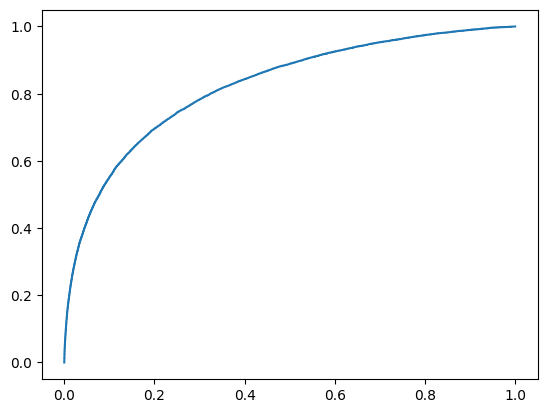

1 0 1 0.823271804427175
1 0 3 2019 2018 2006
torch.Size([14, 64719, 128])


In [ ]:
deltas = [1,3,5]
cutoffs = [0,5,25]
minedge = [1,3]
for d in deltas:
  for c in cutoffs:
    for me in minedge:
      if d == 1 and c == 25 and me == 3:
        continue
      fk = "delta_"+str(d)+"_cutoff_"+str(c)+"_minedge_"+str(me)
      transformer_path = os.path.join(full_path, "Transformer-"+fk)
      tc_path = os.path.join(full_path, "TransformerClassifier-"+fk)

      ########## get train and test data for classifier
      data_source = os.path.join(full_path, "SemanticGraph_"+fk+".pkl")
      with open(data_source, "rb" ) as pkl_file:
        full_dynamic_graph_sparse, X_test, y_test, year_start, years_delta, vertex_degree_cutoff, min_edges = pickle.load(pkl_file)
        all_edge_list, X_train, y_train = create_training_data_biased(full_dynamic_graph_sparse,MAX_TRAIN_YEAR,d,edges_used=100000,vertex_degree_cutoff=me)
      
      # load previously aligned node2vec embeddings in tensor form
      embeddings = torch.load(os.path.join(transformer_path, "embeddings"))
      
      training_set = DatasetClassification(X_train, y_train, embeddings[:-d,:,:]) 
      training_generator = torch.utils.data.DataLoader(training_set, shuffle = True, batch_size = 1024)

      ########## train classifier
      model = torch.load(os.path.join(transformer_path, "model"))
      model_c = TransformerClassifier(model,10,50,d, tc_path)

      checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=tc_path, every_n_epochs = 10)

      trainer = pl.Trainer(gpus=1, 
                default_root_dir=tc_path,
                max_epochs = 50,
                auto_lr_find='lr',
                callbacks = [checkpoint_callback])
      
      trainer.fit(model_c, training_generator)

      ########## test classifier
      test_set = DatasetClassification(X_test, y_test, embeddings[d:,:,:]) # So train and test get same length sequence. 
      test_generator = torch.utils.data.DataLoader(test_set, shuffle = False, batch_size = 5000)

      R = trainer.test(model = model_c, dataloaders=test_generator)

      ########## calculate AUC
      s = torch.tensor([])
      for i in range(2000):
        y_pred = torch.load("/content/drive/MyDrive/science4cast/20220203/TransformerClassifier-"+fk+"/"+str(i)).flatten()
        s = torch.cat((s,y_pred))

      y_pred = s.numpy()
      sorted_predictions_train=np.flip(np.argsort(y_pred,axis=0)) 

      AUC = calculate_ROC(sorted_predictions_train,np.array(y_test),True)

      print(d,c,me,AUC)

